### Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import tweepy
import os
from timeit import default_timer as timer
import seaborn as sns

### Gathering data:

In [2]:
df_main = pd.read_csv('twitter-archive-enhanced.csv')
image_pred = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('image-predictions.tsv','wb') as f:
    f.write(image_pred.content)
df_pred =  pd.read_csv('image-predictions.tsv',sep = '\t')
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### Downloading tweets data using tweepy.

In [143]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

tweet_ids = df_main.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Fail
2: 892177421306343426
Fail
3: 891815181378084864
Fail
4: 891689557279858688
Fail
5: 891327558926688256
Fail
6: 891087950875897856
Fail
7: 890971913173991426
Fail
8: 890729181411237888
Fail
9: 890609185150312448
Fail
10: 890240255349198849
Fail
11: 890006608113172480
Fail
12: 889880896479866881
Fail
13: 889665388333682689
Fail
14: 889638837579907072
Fail
15: 889531135344209921
Fail
16: 889278841981685760
Fail
17: 888917238123831296
Fail
18: 888804989199671297
Fail
19: 888554962724278272
Fail
20: 888202515573088257
Fail
21: 888078434458587136
Fail
22: 887705289381826560
Fail
23: 887517139158093824
Fail
24: 887473957103951883
Fail
25: 887343217045368832
Fail
26: 887101392804085760
Fail
27: 886983233522544640
Fail
28: 886736880519319552
Fail
29: 886680336477933568
Fail
30: 886366144734445568
Fail
31: 886267009285017600
Fail
32: 886258384151887873
Fail
33: 886054160059072513
Fail
34: 885984800019947520
Fail
35: 885528943205470208
Fail
36: 885518971528720385
Fail
3

Fail
288: 838561493054533637
Fail
289: 838476387338051585
Fail
290: 838201503651401729
Fail
291: 838150277551247360
Fail
292: 838085839343206401
Fail
293: 838083903487373313
Fail
294: 837820167694528512
Fail
295: 837482249356513284
Fail
296: 837471256429613056
Fail
297: 837366284874571778
Fail
298: 837110210464448512
Fail
299: 837012587749474308
Fail
300: 836989968035819520
Fail
301: 836753516572119041
Fail
302: 836677758902222849
Fail
303: 836648853927522308
Fail
304: 836397794269200385
Fail
305: 836380477523124226
Fail
306: 836260088725786625
Fail
307: 836001077879255040
Fail
308: 835685285446955009
Fail
309: 835574547218894849
Fail
310: 835536468978302976
Fail
311: 835309094223372289
Fail
312: 835297930240217089
Fail
313: 835264098648616962
Fail
314: 835246439529840640
Fail
315: 835172783151792128
Fail
316: 835152434251116546
Fail
317: 834931633769889797
Fail
318: 834786237630337024
Fail
319: 834574053763584002
Fail
320: 834477809192075265
Fail
321: 834458053273591808
Fail
322: 8342

KeyboardInterrupt: 

In [ ]:
len(fails_dict)
# I downloaded the tweets data by myself but some tweets returned errors so I used the provided file.

#### Reading the JSON file into a DataFrame.

In [3]:
tweets_list = []
with open('tweet-json.txt','r') as f:
    for tweet_str in f:
        first_media_url = np.nan
        is_retweet = False
        retweeted_status_id_str = np.nan
        
        tweet_json = json.loads(tweet_str)
        tweet_id = tweet_json['id']
        tweet_id_str = tweet_json['id_str']
        source = tweet_json['source']

        if 'extended_entities' in tweet_json.keys():
            first_media_url = tweet_json['extended_entities']['media'][0]['media_url']
            
        retweet_count = tweet_json['retweet_count']     #Primarly needed attributes
        favorite_count = tweet_json['favorite_count']   #Primarly needed attributes
        is_quote_status = tweet_json['is_quote_status']
        
        
        if 'retweeted_status' in tweet_json.keys():
            is_retweet = True
            retweeted_status_id_str = tweet_json['retweeted_status']['id_str']
        in_reply_to_status_id_str = tweet_json['in_reply_to_status_id_str']
        
        tweets_list.append({'tweet_id':tweet_id,'tweet_id_str':tweet_id_str,'source':source,'first_media_url':first_media_url,
                            'retweet_count':retweet_count,'favorite_count':favorite_count,'is_quote_status':is_quote_status,
                            'is_retweet':is_retweet,'retweeted_status_id_str':retweeted_status_id_str,
                            'in_reply_to_status_id_str':in_reply_to_status_id_str,})
        
df_extend = pd.DataFrame(tweets_list)
df_extend.to_csv('tweets_additional_info.csv', index = False)
df_extend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   tweet_id                   2354 non-null   int64 
 1   tweet_id_str               2354 non-null   object
 2   source                     2354 non-null   object
 3   first_media_url            2073 non-null   object
 4   retweet_count              2354 non-null   int64 
 5   favorite_count             2354 non-null   int64 
 6   is_quote_status            2354 non-null   bool  
 7   is_retweet                 2354 non-null   bool  
 8   retweeted_status_id_str    179 non-null    object
 9   in_reply_to_status_id_str  78 non-null     object
dtypes: bool(2), int64(3), object(5)
memory usage: 151.8+ KB


#### Now I have: 
- `df_main`   contains main tweets data.
- `df_pred`   contains image predictions.
- `df_extend` contains the retweets count and favorite count and other attributes.

### Assessing the data:

 ####  <u>Quality: </u>
 
<b>`df_main` table:</b>

&nbsp; &nbsp; 1- `name` contains `Null` values,and stored as None. ==

&nbsp; &nbsp; 2- `in_reply_to_status_id`, `in_reply_to_user_id `,`retweeted_status_id`, and `retweeted_status_user_id` conatains `Null` values.

&nbsp; &nbsp; 3- Dog stages columns contains `Null` values,and stored as None. ==

&nbsp; &nbsp; 4- `rating_denominator` is inconsistent it's not always equals to 10 (I know this rating system isn't seriuos but at least let's fix the denominator at 10). ==

&nbsp; &nbsp; 5- `timestamp` is in wrong data type. == 

&nbsp; &nbsp; 6- `source` is stored in `html` format, and wrong data type. ==

&nbsp; &nbsp; 7- `in_reply_to_status_id`, `in_reply_to_user_id `,`retweeted_status_id`, and `retweeted_status_user_id` are of  wrong datatype and this lead to losing some digits.

&nbsp; &nbsp; 8- Table contains tweets that are retweets or replies. == 

&nbsp; &nbsp; 9- `tweet_id` data type is better to be changed as `int` can lead to data loss. ==

&nbsp; &nbsp; 10- There are tweets with more than one dog_stage. ==

&nbsp; &nbsp; 11- Dog stages columns are of wrong data type. ==


#### <u>Tidiness: </u>

&nbsp; &nbsp; 1- Dog stages values in `df_main` are stored in several columns. ==

&nbsp; &nbsp; 2- Dog stages column headers are values. ==

&nbsp; &nbsp; 3- `expanded_urls` column in `df_main` table contains several values. ==

&nbsp; &nbsp; 4- `expanded_urls` column values should be in another table because it represents another entity.

&nbsp; &nbsp; 5- `in_reply_to_status_id`, `in_reply_to_user_id `,`retweeted_status_id`, and `retweeted_status_user_id` columns headers contains values.

&nbsp; &nbsp; 6- `df_extend` should be merged with the `df_main` table as they represent one observational unit.


In [4]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [5]:
df_extend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   tweet_id                   2354 non-null   int64 
 1   tweet_id_str               2354 non-null   object
 2   source                     2354 non-null   object
 3   first_media_url            2073 non-null   object
 4   retweet_count              2354 non-null   int64 
 5   favorite_count             2354 non-null   int64 
 6   is_quote_status            2354 non-null   bool  
 7   is_retweet                 2354 non-null   bool  
 8   retweeted_status_id_str    179 non-null    object
 9   in_reply_to_status_id_str  78 non-null     object
dtypes: bool(2), int64(3), object(5)
memory usage: 151.8+ KB


In [6]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [7]:
df_main.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [8]:
df_extend.is_quote_status.value_counts()

False    2323
True       31
Name: is_quote_status, dtype: int64

In [9]:
df_extend.is_retweet.value_counts()

False    2175
True      179
Name: is_retweet, dtype: int64

In [10]:
# To make sure no tweet has more than 1 stage
temp_cleaning_dog_stage = (df_main.loc[:,'doggo':'puppo']!= 'None')
temp_cleaning_dog_stage['sum'] = temp_cleaning_dog_stage.sum(axis = 1)
temp_cleaning_dog_stage['sum'].value_counts()

0    1976
1     366
2      14
Name: sum, dtype: int64

### Cleaning the data:

 ####  <u>Define: </u>
 
&nbsp; &nbsp; 1- Change None into `Null` in `name` column.

&nbsp; &nbsp; 2- Try to extract the names for the `Null` values using a list of most popular dogs.

In [11]:
#Define new data frames for the cleaning process:
df_main_clean = df_main.copy()
df_extend_clean = df_extend.copy()
df_pred_clean = df_pred.copy()

In [12]:
df_main_clean.query('name == "None"')['name'].count()

745

In [13]:

df_main_clean['name'].replace('None',np.nan,inplace = True)

 ####  <u>Test: </u>

In [14]:
df_main_clean.query('name == "None"')['name'].count()
df_main_clean['name'].isnull().sum()

745

In [15]:
#Search in text column for a dog name from the list of dog names:
dog_names = ['bella','charlie','luna','lucy','max','bailey','cooper','daisy','sadie','molly','buddy','lola','stella','tucker','bentley','zoey','harley','maggie','riley','bear','sophie','duke','jax','oliver','chloe','jack','penny','rocky','lily','milo','piper','toby','zeus','ellie','nala','roxy','winston','gracie','coco','murphy','dexter','teddy','ruby','diesel','rosie','marley','loki','scout','mia','leo','gus','abby','jake','finn','moose','ollie','koda','louie','hank','lilly','thor','pepper','gunner','willow','jackson','zoe','bandit','buster','blue','shadow','kona','baxter','dixie','henry','lexi','izzy','apollo','ginger','beau','layla','millie','gizmo','oscar','tank','bruno','jasper','lucky','dakota','ace','olive','brody','maverick','lulu','emma','oakley','sasha','belle','nova','athena','sammy','sam','copper','frankie','peanut','maya','winnie','remi','lady','boomer','bo','roxie','hazel','roscoe','annie','maddie','hunter','oreo','otis','ruger','rex','cali','ella','cash','cody','remy','callie','odin','chance','rocco','harper','tyson','ranger','luke','brutus','ziggy','bruce','honey','chewy','george','wrigley','rusty','benny','phoebe','chase','princess','minnie','simba','brady','zeke','remington','paisley','shelby','holly','titan','leia','walter','samson','finley','ava','cookie','angel','mocha','archie','josie','rudy','benji','dozer','maximus','penelope','parker','joey','lincoln','romeo','ryder','kobe','aspen','mac','chief','missy','theo','chewie','axel','dallas','mila','bubba','xena','reese','chester','rufus','whiskey','macy','king','watson','prince','river','sunny','hudson','ivy','juno','kai','abe','abbott','aero','aiden','aj','albert','alden','alex','alfie','alvin','amos','andy','angus','aries','artie','ash','austin','barkley','barney','baron','billy','bingo','blake','blaze','brownie','buck','butch','buzz','cain','captain','carter','casper','champ','chico','chip','cj','clifford','clyde','colby','damien','dane','dante','denver','diego','dodge','drew','dylan','eddie','eli','elmer','emmett','evan','felix','fisher','flash','freddy','fritz','gage','goose','gordie','griffin','harvey','hawkeye','hoss','huck','iggy','ivan','jesse','johnny','judge','kane','lenny','leroy','levi','lewis','logan','marty','mickey','miles','moe','morris','ned','nelson','nero','nico','noah','norm','odie','otto','ozzy','pablo','petey','porter','quincy','radar','ralph','rambo','rascal','rebel','reggie','ricky','rider','ringo','rockwell','rosco','sarge','sawyer','scooby','scooter','scrappy','shamus','shiloh','simon','smoky','snoopy','sparky','spencer','spike','spot','stanley','stewie','storm','taco','taz','tesla','titus','tj','trapper','tripp','tyler','vince','vinnie','wally','willy','woody','wyatt','yogi','yoshi','yukon','zane','addie','alexis','alice','allie','alyssa','amber','anna','ariel','ashley','autumn','avery','baby','basil','bean','betsy','betty','bianca','birdie','biscuit','blondie','blossom','bonnie','brandy','brooklyn','buffy','camilla','candy','carla','carly','carmela','casey','cassie','chanel','cinnamon','cleo','cricket','dana','daphne','darla','darlene','delia','delilah','destiny','diamond','diva','dolly','duchess','eden','edie','elsa','emmy','eva','faith','fanny','fern','fiona','foxy','gabby','gemma','georgia','gia','gidget','gigi','goldie','grace','greta','gypsy','hailey','hannah','heidi','hershey','hope','ibby','inez','isabella','jackie','jada','jade','jasmine','jenna','jersey','jessie','jill','julia','juliet','kali','kallie','karma','kate','katie','kayla','kelsey','khloe','kiki','kira','koko','lacy','lena','libby','liberty','lizzy','london','mabel','mackenzie','madison','maisy','mandy','matilda','mattie','mika','miley','mimi','misty','mitzi','morgan','moxie','muffin','mya','nell','nellie','nikki','nina','noel','nola','nori','olivia','pandora','paris','peaches','pearl','pebbles','pippa','pixie','polly','poppy','precious','priscilla','raven','rose','sage','sally','samantha','sammie','sandy','sassy','savannah','scarlet','sheba','sierra','sissy','sky','smokey','snickers','sophia','star','sugar','suki','summer','sweetie','sydney','tasha','tessa','tilly','tootsie','trixie','violet','zelda','peanuts','rascals','daktoa','lacey']

In [16]:
for i in range(0,len(df_main_clean)):
    if df_main_clean.loc[i,'name'] is np.nan:
        for possible_name in dog_names:
            if possible_name in df_main_clean.loc[i,'text'].lower():
                df_main_clean.loc[i,'name'] = possible_name.capitalize()


 ####  <u>Test: </u>

In [17]:
df_main_clean['name'].isnull().sum() 
#Reduced the null values in the name column, other names are either unaviable in text or not in my list.

403

####  <u>Define: </u>

&nbsp; &nbsp; 1- Change None into `Null` in dog stages columns.

&nbsp; &nbsp; 2- Fix the tweets of more than one dog stage.

&nbsp; &nbsp; 3- Use `melt` function to change Dog stages columns into one column

&nbsp; &nbsp; 4- Try to extract Dog stages from the `text` column.

&nbsp; &nbsp; 5- Change `dog_stage` data typr to category.

&nbsp; &nbsp; 6- Fill `Null` in `dog_stage` column with an arbitrary category.



In [18]:
#Replace None with Null
df_main_clean['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [19]:
df_main_clean['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [20]:
df_main_clean['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [21]:
df_main_clean['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [22]:
df_main_clean['doggo'].replace('None',np.nan,inplace = True)
df_main_clean['floofer'].replace('None',np.nan,inplace = True)
df_main_clean['pupper'].replace('None',np.nan,inplace = True)
df_main_clean['puppo'].replace('None',np.nan,inplace = True)

 ####  <u>Test: </u>

In [23]:
print(df_main_clean['floofer'].value_counts(),'--',df_main_clean['floofer'].isnull().sum())

floofer    10
Name: floofer, dtype: int64 -- 2346


In [24]:
df_main_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1953 non-null   object 
 13  doggo                       97 no

In [25]:
# Fixing the tweets with 2 dog stages (Since there are 14 only I will check the tweets visually to verify dog stage using picture)
temp = df_main_clean.iloc[:,np.r_[0,13:17]]
temp = pd.merge(temp,temp.loc[:,'doggo':'puppo'].notnull(),left_index = True,right_index = True)
temp['count_occ_dog_stage'] = temp.iloc[:,5:].sum(axis = 1)
temp['count_occ_dog_stage'].value_counts()

0    1976
1     366
2      14
Name: count_occ_dog_stage, dtype: int64

In [26]:
#Get tweets id for those who have more than dog stage
temp[temp['count_occ_dog_stage'] == 2]['tweet_id']


191     855851453814013952
200     854010172552949760
460     817777686764523521
531     808106460588765185
565     802265048156610565
575     801115127852503040
705     785639753186217984
733     781308096455073793
778     775898661951791106
822     770093767776997377
889     759793422261743616
956     751583847268179968
1063    741067306818797568
1113    733109485275860992
Name: tweet_id, dtype: int64

In [27]:
#Checking these tweets
#df_main_clean[df_main_clean['tweet_id'] == 808106460588765185]
# 191     855851453814013952 ====> puppo
# 200     854010172552949760 ====> doggo
# 460     817777686764523521 ====> pupper
# 531     808106460588765185 ====> pupper
# 565     802265048156610565 ====> pupper 
# 575     801115127852503040 ====> pupper 
# 705     785639753186217984 ====> pupper
# 733     781308096455073793 ====> pupper
# 778     775898661951791106 ====> doggo
# 822     770093767776997377 ====> doggo
# 889     759793422261743616 ====> pupper
# 956     751583847268179968 ====> doggo
# 1063    741067306818797568 ====> pupper
# 1113    733109485275860992 ====> doggo
rows = temp[temp['count_occ_dog_stage'] == 2]['tweet_id'].index
rows_range = np.r_[rows]
cols_range = np.r_[13,14,15,16]
df_main_clean.iloc[rows_range,cols_range] = np.nan
df_main_clean.iloc[rows_range,cols_range]
indecies_list = list(rows)
dog_stage_list = ['puppo','doggo','pupper','pupper','pupper','pupper','pupper','pupper','doggo','doggo','pupper','doggo','pupper','doggo']

for i in range(0,len(indecies_list)):
    df_main_clean.loc[indecies_list[i] , dog_stage_list[i]] = dog_stage_list[i]


df_main_clean.iloc[rows_range,cols_range]

,doggo,floofer,pupper,puppo
191,NaN,NaN,NaN,puppo
200,doggo,NaN,NaN,NaN
460,NaN,NaN,pupper,NaN
531,NaN,NaN,pupper,NaN
565,NaN,NaN,pupper,NaN
575,NaN,NaN,pupper,NaN
705,NaN,NaN,pupper,NaN
733,NaN,NaN,pupper,NaN
778,doggo,NaN,NaN,NaN
822,doggo,NaN,NaN,NaN


 ####  <u>Test: </u>

In [28]:
temp = df_main_clean.iloc[:,np.r_[0,13:17]]
temp = pd.merge(temp,temp.loc[:,'doggo':'puppo'].notnull(),left_index = True,right_index = True)
temp['count_occ_dog_stage'] = temp.iloc[:,5:].sum(axis = 1)
temp['count_occ_dog_stage'].value_counts()

0    1976
1     380
Name: count_occ_dog_stage, dtype: int64

In [29]:
#Changing dog stages columns into one column
df_main_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [30]:
# Melting:(Columns that won't be used in melting)
id_cols = ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name']

In [31]:
#I'll devide the datafarame into two parts, one part consists of rows that contain value for dog_stage and other do not
#After melting the first one I'll append it to the next 
df_with_dog_stage = df_main_clean[(df_main_clean['doggo'] == 'doggo')| (df_main_clean['floofer'] == 'floofer')|(df_main_clean['pupper'] == 'pupper')|(df_main_clean['puppo'] =='puppo')]
df_without_dog_stage = df_main_clean[(df_main_clean['doggo'] != 'doggo')&(df_main_clean['floofer'] != 'floofer')&(df_main_clean['pupper'] != 'pupper')&(df_main_clean['puppo'] !='puppo')]



In [32]:
df_with_dog_stage = pd.melt(df_with_dog_stage,id_cols,var_name = 'delete_col',value_name = 'dog_stage')
df_with_dog_stage = df_with_dog_stage[df_with_dog_stage['dog_stage'].notnull()]
df_with_dog_stage.drop(['delete_col'],axis =1,inplace = True)

df_without_dog_stage.drop(['doggo','floofer','pupper','puppo'],axis = 1,inplace = True)
df_without_dog_stage.loc[:,'dog_stage'] = np.nan

D:\Programs\ApplicationsSetup\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
D:\Programs\ApplicationsSetup\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Programs\ApplicationsSetup\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [33]:
df_main_clean = df_without_dog_stage.append(df_with_dog_stage)
df_main_clean = df_main_clean.reset_index(drop = True)

 ####  <u>Test: </u>

In [34]:
df_main_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1953 non-null   object 
 13  dog_stage                   380 n

##### We can see that number of tweets that contains a dog_stage are --380-- Only., So we'll try to extract values from the rest of the tweets.

In [35]:
dog_stages = ['doggo','floofer','pupper','puppo']

for i in range(0,len(df_main_clean)):
    if df_main_clean.loc[i,'dog_stage'] is np.nan:
        for possible_stage in dog_stages:
            if possible_stage in df_main_clean.loc[i,'text'].lower():
                df_main_clean.loc[i,'dog_stage'] = possible_stage
# Can't fill any dog stages from the text

In [36]:
#I'll fill the Null values with an arbitrary category then changing data typr to category:
df_main_clean.dog_stage.fillna('unknown',inplace = True)
df_main_clean.dog_stage = df_main_clean.dog_stage.astype('category')

In [37]:
#Test:
df_main_clean.dog_stage.value_counts()

unknown    1976
pupper      253
doggo        88
puppo        30
floofer       9
Name: dog_stage, dtype: int64

####  <u>Define: </u>

&nbsp; &nbsp; 1- Change `timestamp` data type into date time.

&nbsp; &nbsp; 2- Change `retweeted_status_timestamp` data type into date time.

&nbsp; &nbsp; 3- Change `source` content into a readable text, and change it's data type to category.

&nbsp; &nbsp; 4- Change `tweet_id` data type to `string`.

In [38]:
df_main_clean.timestamp = pd.to_datetime(df_main_clean.timestamp)
df_main_clean.retweeted_status_timestamp = pd.to_datetime(df_main_clean.retweeted_status_timestamp)

In [39]:
df_main_clean.source = df_main_clean.source.str.extract(">(\D+)<")

In [40]:
df_main_clean.source = df_main_clean.source.astype('category')

In [41]:
df_main_clean.tweet_id = df_main_clean.tweet_id.astype('str')

 ####  <u>Test: </u>

In [42]:
df_main_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   category           
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [43]:
df_main_clean.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

####  <u>Define: </u>

&nbsp; &nbsp; 1- Transfer the column `expanded_urls` to another table as it represents another observatory unit.

&nbsp; &nbsp; 2- Drop the column `expanded_urls` from `df_main_clean`.

&nbsp; &nbsp; 3- Drop the rows with `Null` values in `expanded_urls` column from the new table.

&nbsp; &nbsp; 4- Transform multiple values to multiple rows in the new table.


In [44]:
df_main_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   category           
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

####  <u>Define: </u>

&nbsp; &nbsp; 1- Make all the values of the `rating_denominator ` constant (equals to 10) and changing the value of the `rating_numerator` accordingly.


In [45]:
df_main_clean.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [46]:
#Fixing a wrong denominator of value 0.
df_main_clean.loc[273,'rating_denominator'] = 10
df_main_clean.loc[273,'rating_numerator'] = 13
for i in range(0,len(df_main_clean)):
    if df_main_clean.loc[i,'rating_denominator'] != 10:
        df_main_clean.loc[i,'rating_numerator'] = int(10*df_main_clean.loc[i,'rating_numerator']/df_main_clean.loc[i,'rating_denominator'])
        df_main_clean.loc[i,'rating_denominator'] = 10

In [47]:
df_main_clean.rating_denominator.value_counts()

10    2356
Name: rating_denominator, dtype: int64

####  <u>Define: </u>

&nbsp; &nbsp; 1- Since `in_reply_to_status_id`, `in_reply_to_user_id `,`retweeted_status_id`, and `retweeted_status_user_id` conatains `Null` values, and we only need the original Tweets,So I'll drop these columns and drop the rows that are considered a reply or retweet. <b> 259 rows will be dropped. which are either replies or retweets.</b>


In [48]:
df_main_clean = df_main_clean[(df_main_clean['in_reply_to_status_id'].isnull())& (df_main_clean['retweeted_status_id'].isnull())]
cols_to_drop = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_timestamp','retweeted_status_user_id']
df_main_clean.drop(cols_to_drop,axis = 1,inplace = True)
df_main_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   category           
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                1761 non-null   object             
 8   dog_stage           2097 non-null   category           
dtypes: category(2), datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 135.5+ KB


<b> Now There is only one column that contains `Null` values `name`. </b>

####  <u>Define: </u>

&nbsp; &nbsp; 1- Drop all columns in `df_extend_clean` except for `retweet_count`, `favorite_count`, and `tweet_id_str`.

&nbsp; &nbsp; 2- Merge `df_extend_clean` and `df_main_clean`.



In [49]:
df_extend_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   tweet_id                   2354 non-null   int64 
 1   tweet_id_str               2354 non-null   object
 2   source                     2354 non-null   object
 3   first_media_url            2073 non-null   object
 4   retweet_count              2354 non-null   int64 
 5   favorite_count             2354 non-null   int64 
 6   is_quote_status            2354 non-null   bool  
 7   is_retweet                 2354 non-null   bool  
 8   retweeted_status_id_str    179 non-null    object
 9   in_reply_to_status_id_str  78 non-null     object
dtypes: bool(2), int64(3), object(5)
memory usage: 151.8+ KB


In [50]:
df_extend_clean = df_extend_clean.iloc[:,np.r_[1,4,5]]


In [51]:
df_extend_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id_str    2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


In [52]:
df_main_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   category           
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                1761 non-null   object             
 8   dog_stage           2097 non-null   category           
dtypes: category(2), datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 135.5+ KB


In [53]:
df_main_clean = pd.merge(df_main_clean,df_extend_clean,how = 'inner',left_on = 'tweet_id',right_on = 'tweet_id_str')

In [54]:
df_main_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,tweet_id_str,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,unknown,892420643555336193,8853,39467
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,unknown,892177421306343426,6514,33819
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,unknown,891815181378084864,4328,25461
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,unknown,891689557279858688,8964,42908
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,unknown,891327558926688256,9774,41048
...,...,...,...,...,...,...,...,...,...,...,...,...
2092,752519690950500352,2016-07-11 15:07:30+00:00,Twitter for iPhone,Hopefully this puppo on a swing will help get ...,https://twitter.com/dog_rates/status/752519690...,11,10,Hope,puppo,752519690950500352,3917,8157
2093,751132876104687617,2016-07-07 19:16:47+00:00,Twitter for iPhone,This is Cooper. He's just so damn happy. 10/10...,https://twitter.com/dog_rates/status/751132876...,10,10,Cooper,puppo,751132876104687617,1480,5610
2094,744995568523612160,2016-06-20 20:49:19+00:00,Twitter for iPhone,This is Abby. She got her face stuck in a glas...,https://twitter.com/dog_rates/status/744995568...,9,10,Abby,puppo,744995568523612160,716,3277
2095,743253157753532416,2016-06-16 01:25:36+00:00,Twitter for iPhone,This is Kilo. He cannot reach the snackum. Nif...,https://twitter.com/dog_rates/status/743253157...,10,10,Kilo,puppo,743253157753532416,1366,4624


In [55]:
df_main_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   category           
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                1761 non-null   object             
 8   dog_stage           2097 non-null   category           
 9   tweet_id_str        2097 non-null   object             
 10  retweet_count       2097 non-null   int64              
 11  favorite_count      2097 non-null   int64              
dtypes: category(2), datetime64[ns, UTC

In [56]:
#Merging the image prediction data frame with the main data frame
df_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [57]:
#Changing column names to more deescriptive names
new_cols = ['tweet_id','jpg_url','img_num','first_prediction','first_prediction_conf','first_prediction_is_dog','second_prediction','second_prediction_conf','second_prediction_is_dog','third_prediction','third_prediction_conf','third_prediction_is_dog']
df_pred_clean.columns = new_cols
df_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tweet_id                  2075 non-null   int64  
 1   jpg_url                   2075 non-null   object 
 2   img_num                   2075 non-null   int64  
 3   first_prediction          2075 non-null   object 
 4   first_prediction_conf     2075 non-null   float64
 5   first_prediction_is_dog   2075 non-null   bool   
 6   second_prediction         2075 non-null   object 
 7   second_prediction_conf    2075 non-null   float64
 8   second_prediction_is_dog  2075 non-null   bool   
 9   third_prediction          2075 non-null   object 
 10  third_prediction_conf     2075 non-null   float64
 11  third_prediction_is_dog   2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [58]:
#Change tweet id column data type to string
df_pred_clean.tweet_id = df_pred_clean.tweet_id.astype(str)

In [59]:
#Merging the 2 data sets
df_main_clean = pd.merge(df_main_clean,df_pred_clean,how = 'left',left_on = 'tweet_id',right_on = 'tweet_id')

In [60]:
df_main_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   tweet_id                  2097 non-null   object             
 1   timestamp                 2097 non-null   datetime64[ns, UTC]
 2   source                    2097 non-null   category           
 3   text                      2097 non-null   object             
 4   expanded_urls             2094 non-null   object             
 5   rating_numerator          2097 non-null   int64              
 6   rating_denominator        2097 non-null   int64              
 7   name                      1761 non-null   object             
 8   dog_stage                 2097 non-null   category           
 9   tweet_id_str              2097 non-null   object             
 10  retweet_count             2097 non-null   int64              
 11  favorite_count   

<b>This is the resulting DataFrame ==> `df_main_clean`</b>

In [61]:
df_main_clean.drop('tweet_id_str',axis = 1,inplace = True)


In [62]:
df_main_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   tweet_id                  2097 non-null   object             
 1   timestamp                 2097 non-null   datetime64[ns, UTC]
 2   source                    2097 non-null   category           
 3   text                      2097 non-null   object             
 4   expanded_urls             2094 non-null   object             
 5   rating_numerator          2097 non-null   int64              
 6   rating_denominator        2097 non-null   int64              
 7   name                      1761 non-null   object             
 8   dog_stage                 2097 non-null   category           
 9   retweet_count             2097 non-null   int64              
 10  favorite_count            2097 non-null   int64              
 11  jpg_url          

### Storing the data:

In [63]:
df_main_clean.to_csv('twitter_archive_master.csv',index = False)

### Analyzing and Visualization of the data:

In [64]:
#I'll extract month, year and week day to other column from timestamp column
df_main_clean['year'] = df_main_clean['timestamp'].dt.year
df_main_clean['month'] = df_main_clean['timestamp'].dt.month
df_main_clean['year_month'] = df_main_clean['year'].map(str) + ' - ' + df_main_clean['month'].map(str)
df_main_clean['week_day'] = df_main_clean['timestamp'].dt.day_name()

In [65]:
df_main_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   tweet_id                  2097 non-null   object             
 1   timestamp                 2097 non-null   datetime64[ns, UTC]
 2   source                    2097 non-null   category           
 3   text                      2097 non-null   object             
 4   expanded_urls             2094 non-null   object             
 5   rating_numerator          2097 non-null   int64              
 6   rating_denominator        2097 non-null   int64              
 7   name                      1761 non-null   object             
 8   dog_stage                 2097 non-null   category           
 9   retweet_count             2097 non-null   int64              
 10  favorite_count            2097 non-null   int64              
 11  jpg_url          

In [66]:
df_main_clean.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

In [67]:
df_main_clean.timestamp.min()

Timestamp('2015-11-15 22:32:08+0000', tz='UTC')

In [68]:
df_main_clean.timestamp.max()

Timestamp('2017-08-01 16:23:56+0000', tz='UTC')

In [69]:
df_main_clean.describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,first_prediction_conf,second_prediction_conf,third_prediction_conf,year,month
count,2097.000000,2097.0,2097.000000,2097.000000,1971.000000,1971.000000,1.971000e+03,1.971000e+03,2097.000000,2097.000000
mean,11.692418,10.0,2841.667620,8980.902241,1.201928,0.594558,1.345850e-01,6.016556e-02,2015.860277,7.057701
std,39.659275,0.0,4709.238203,12199.636684,0.559020,0.272126,1.010527e-01,5.094156e-02,0.691435,4.116042
min,0.000000,10.0,16.000000,81.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,2015.000000,1.000000
25%,10.000000,10.0,644.000000,2046.000000,1.000000,0.363091,5.339800e-02,1.608055e-02,2015.000000,3.000000
50%,11.000000,10.0,1405.000000,4196.000000,1.000000,0.587764,1.173970e-01,4.944380e-02,2016.000000,7.000000
75%,12.000000,10.0,3285.000000,11416.000000,1.000000,0.847827,1.955655e-01,9.153815e-02,2016.000000,11.000000
max,1776.000000,10.0,79515.000000,132810.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,2017.000000,12.000000


In [70]:
#Tweet that had the most retweets:
df_main_clean.loc[df_main_clean['retweet_count'].idxmax(),:]



tweet_id                                                   744234799360020481
timestamp                                           2016-06-18 18:26:18+00:00
source                                                     Twitter for iPhone
text                        Here's a doggo realizing you can stand in a po...
expanded_urls               https://twitter.com/dog_rates/status/744234799...
rating_numerator                                                           13
rating_denominator                                                         10
name                                                                      Ned
dog_stage                                                               doggo
retweet_count                                                           79515
favorite_count                                                         131075
jpg_url                     https://pbs.twimg.com/ext_tw_video_thumb/74423...
img_num                                                         

In [71]:
#Tweet that had the most favorites 
df_main_clean.loc[df_main_clean['favorite_count'].idxmax(),:]

tweet_id                                                   822872901745569793
timestamp                                           2017-01-21 18:26:02+00:00
source                                                     Twitter for iPhone
text                        Here's a super supportive puppo participating ...
expanded_urls               https://twitter.com/dog_rates/status/822872901...
rating_numerator                                                           13
rating_denominator                                                         10
name                                                                      NaN
dog_stage                                                               puppo
retweet_count                                                           48265
favorite_count                                                         132810
jpg_url                       https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg
img_num                                                         

In [72]:
#Each Year average
df_main_clean.groupby(df_main_clean.year).mean().loc[:,'retweet_count':'favorite_count']
#We can see that the year '2017' had the hieghest average of retweets and favorite count

,retweet_count,favorite_count
year,,
2015,1111.652695,2545.619760
2016,2831.055028,7775.229602
2017,5953.229333,23833.029333


In [73]:
#Average Retweets and Favorite for every month in every year
df_avg_year_month = df_main_clean.groupby(df_main_clean.year_month).mean().loc[:,'retweet_count':'favorite_count']
df_avg_year_month

,retweet_count,favorite_count
year_month,,
2015 - 11,543.756757,1241.793919
2015 - 12,1563.526882,3583.072581
2016 - 1,1664.224044,4179.497268
2016 - 10,4634.222222,13819.097222
2016 - 11,4810.870370,14593.611111
2016 - 12,5618.824561,16404.929825
2016 - 2,1555.247934,4130.082645
2016 - 3,1768.295455,4692.212121
2016 - 4,1627.900000,4668.383333


In [74]:
df_avg_year_month.describe()
#We can see that the date '2017 - August' had the hieghest average of retweets and favorite count

,retweet_count,favorite_count
count,22.000000,22.000000
mean,4102.696004,14508.897051
std,2171.352387,10346.727768
min,543.756757,1241.793919
25%,1888.141082,5073.146379
50%,4202.891503,12461.425423
75%,5726.616855,20265.885173
max,7683.500000,36643.000000


In [75]:
#Number of original tweets in every month of every year:
df_main_clean.groupby(df_main_clean.year_month).count().loc[:,'retweet_count':'favorite_count']
# Month with highest tweets is '2015 - 12' and the least is '2017 - 8'

,retweet_count,favorite_count
year_month,,
2015 - 11,296,296
2015 - 12,372,372
2016 - 1,183,183
2016 - 10,72,72
2016 - 11,54,54
2016 - 12,57,57
2016 - 2,121,121
2016 - 3,132,132
2016 - 4,60,60


In [76]:
#Sum of Retweets or Favorite in every month of every year:
df_sum_montly = df_main_clean.groupby([df_main_clean.year,df_main_clean.month]).sum().loc[:,'retweet_count':'favorite_count']
df_sum_montly
#Month with highest retweets is '2015- 12' and the least is '2017 - 8' 
#Month with highest favorites is '2017 - 7' and the least is '2017 - 8' 

retweet_count  favorite_count
year month                               
2015 11            160952          367571
     12            581632         1332903
2016 1             304553          764848
     2             188185          499740
     3             233415          619372
     4              97674          280103
     5             132613          366741
     6             371879          845725
     7             271731          714892
     8             220630          619401
     9             249528          766159
     10            333664          994975
     11            259787          788055
     12            320273          935081
2017 1             427323         1316207
     2             290618         1228776
     3             257986         1074460
     4             242027          964846
     5             323109         1240533
     6             314276         1385809
     7             361755         1653469
     8              15367           73286

In [77]:
df_average_daily = df_main_clean.groupby(df_main_clean.timestamp.dt.date).mean().loc[:,'retweet_count':'favorite_count']
df_average_daily

,retweet_count,favorite_count
timestamp,,
2015-11-15,209.000000,931.666667
2015-11-16,432.720000,873.560000
2015-11-17,149.800000,302.133333
2015-11-18,234.941176,519.705882
2015-11-19,1407.260870,3501.347826
...,...,...
2017-07-28,9437.000000,34444.500000
2017-07-29,6517.500000,30805.000000
2017-07-30,8964.000000,42908.000000


In [78]:
#You can see here the value of the highest and lowest average retweets and favorite for each day 
df_average_daily

,retweet_count,favorite_count
timestamp,,
2015-11-15,209.000000,931.666667
2015-11-16,432.720000,873.560000
2015-11-17,149.800000,302.133333
2015-11-18,234.941176,519.705882
2015-11-19,1407.260870,3501.347826
...,...,...
2017-07-28,9437.000000,34444.500000
2017-07-29,6517.500000,30805.000000
2017-07-30,8964.000000,42908.000000


In [79]:
print(df_average_daily.retweet_count.idxmax())
print(df_average_daily.retweet_count.idxmin())

print(df_average_daily.favorite_count.idxmax())
print(df_average_daily.favorite_count.idxmin())

2016-12-09
2015-11-17
2016-12-09
2015-11-17


In [80]:
# DataFrame with retweet count and favorite count and id only
df_fav_and_ret_only = df_main_clean.copy()
df_fav_and_ret_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   tweet_id                  2097 non-null   object             
 1   timestamp                 2097 non-null   datetime64[ns, UTC]
 2   source                    2097 non-null   category           
 3   text                      2097 non-null   object             
 4   expanded_urls             2094 non-null   object             
 5   rating_numerator          2097 non-null   int64              
 6   rating_denominator        2097 non-null   int64              
 7   name                      1761 non-null   object             
 8   dog_stage                 2097 non-null   category           
 9   retweet_count             2097 non-null   int64              
 10  favorite_count            2097 non-null   int64              
 11  jpg_url          

In [81]:
df_fav_and_ret_only['retweet_count/sum_retweet_per_month'] = np.nan
df_fav_and_ret_only['favorite_count/sum_favorite_per_month'] = np.nan
i = 0
for i in range(len(df_fav_and_ret_only)):
    year = df_fav_and_ret_only.iloc[i,22]
    month = df_fav_and_ret_only.iloc[i,23]
    sum_ret_curr = df_sum_montly.query('year ==' + str(year) + 'and month ==' + str(month))['retweet_count'].iloc[0]
    sum_fav_curr = df_sum_montly.query('year ==' + str(year) + 'and month ==' + str(month))['favorite_count'].iloc[0]
    df_fav_and_ret_only.iloc[i,26] = 100 * df_fav_and_ret_only.iloc[i,9] / sum_ret_curr
    df_fav_and_ret_only.iloc[i,27] = 100 *df_fav_and_ret_only.iloc[i,10] / sum_fav_curr

In [82]:
#From this I'll find out which Tweet has the most retweets or favorites percentage
df_fav_and_ret_only

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,...,second_prediction_is_dog,third_prediction,third_prediction_conf,third_prediction_is_dog,year,month,year_month,week_day,retweet_count/sum_retweet_per_month,favorite_count/sum_favorite_per_month
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,unknown,8853,...,False,banana,0.076110,False,2017,8,2017 - 8,Tuesday,57.610464,53.853396
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,unknown,6514,...,True,papillon,0.068957,True,2017,8,2017 - 8,Tuesday,42.389536,46.146604
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,unknown,4328,...,True,kelpie,0.031379,True,2017,7,2017 - 7,Monday,1.196390,1.539853
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,unknown,8964,...,True,spatula,0.040836,False,2017,7,2017 - 7,Sunday,2.477920,2.595029
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,unknown,9774,...,True,German_short-haired_pointer,0.175219,True,2017,7,2017 - 7,Saturday,2.701829,2.482538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,752519690950500352,2016-07-11 15:07:30+00:00,Twitter for iPhone,Hopefully this puppo on a swing will help get ...,https://twitter.com/dog_rates/status/752519690...,11,10,Hope,puppo,3917,...,True,Eskimo_dog,0.000001,True,2016,7,2016 - 7,Monday,1.441499,1.141012
2093,751132876104687617,2016-07-07 19:16:47+00:00,Twitter for iPhone,This is Cooper. He's just so damn happy. 10/10...,https://twitter.com/dog_rates/status/751132876...,10,10,Cooper,puppo,1480,...,True,golden_retriever,0.007610,True,2016,7,2016 - 7,Thursday,0.544656,0.784734
2094,744995568523612160,2016-06-20 20:49:19+00:00,Twitter for iPhone,This is Abby. She got her face stuck in a glas...,https://twitter.com/dog_rates/status/744995568...,9,10,Abby,puppo,716,...,True,Tibetan_terrier,0.134269,True,2016,6,2016 - 6,Monday,0.192536,0.387478
2095,743253157753532416,2016-06-16 01:25:36+00:00,Twitter for iPhone,This is Kilo. He cannot reach the snackum. Nif...,https://twitter.com/dog_rates/status/743253157...,10,10,Kilo,puppo,1366,...,True,Eskimo_dog,0.177822,True,2016,6,2016 - 6,Thursday,0.367324,0.546750


In [83]:
df_fav_and_ret_only.loc[df_fav_and_ret_only['retweet_count/sum_retweet_per_month'].idxmax(),:]

tweet_id                                                                892420643555336193
timestamp                                                        2017-08-01 16:23:56+00:00
source                                                                  Twitter for iPhone
text                                     This is Phineas. He's a mystical boy. Only eve...
expanded_urls                            https://twitter.com/dog_rates/status/892420643...
rating_numerator                                                                        13
rating_denominator                                                                      10
name                                                                               Phineas
dog_stage                                                                          unknown
retweet_count                                                                         8853
favorite_count                                                                       39467

In [84]:
df_fav_and_ret_only['favorite_count/sum_favorite_per_month'].max()

53.853396283055424

In [85]:
#To see which week day gets maximum number of retweets or favorite i'm going to group by week day
df_weekday = df_main_clean.groupby('week_day').mean().loc[:,'retweet_count':'favorite_count']
df_weekday = df_weekday.reindex(index = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday'])
df_weekday
#We can see here that in general favorites are greater than retweets
#Also 'Wednesday' in average got more favorite counts and also more retweet counts

,retweet_count,favorite_count
week_day,,
Saturday,2997.817164,9102.492537
Sunday,2694.261194,8741.899254
Monday,2729.164773,8645.923295
Tuesday,2755.500000,9056.009615
Wednesday,3281.306452,10174.470968
Thursday,2606.830508,8412.667797
Friday,2831.842466,8719.150685


Text(0, 0.5, 'favorite count')

<Figure size 0x0 with 0 Axes>

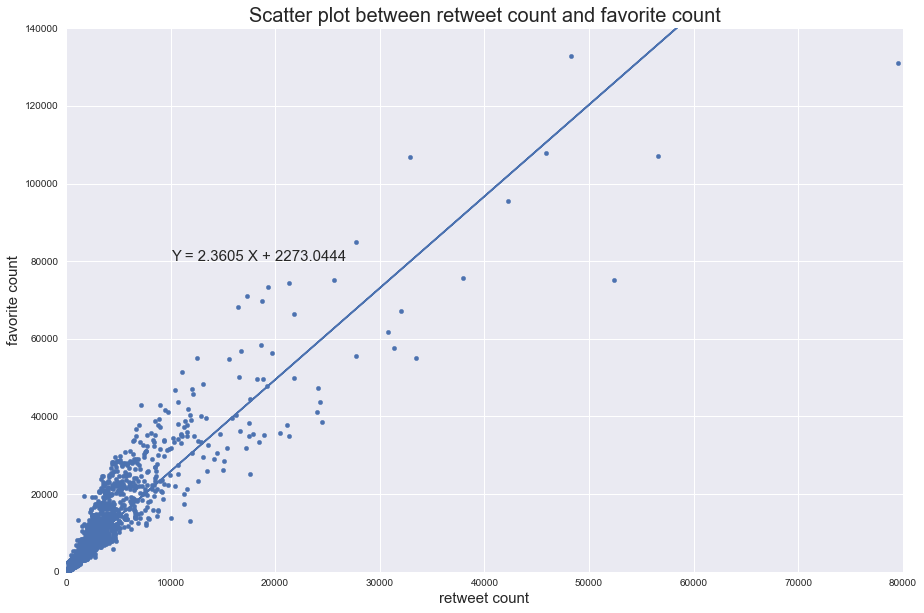

In [98]:
#Draw scatter between retweet & favorite
plt.figure(dpi=0)
plt.style.use(plt.style.available[9])
df_main_clean.plot(x = 'retweet_count' , y = 'favorite_count' , kind = 'scatter',figsize=(15,10))

x1 = df_main_clean['retweet_count']
y1 = df_main_clean['favorite_count']
coeff = np.polyfit(x1,y1,1)
z = np.poly1d(coeff)
eqn_str = 'Y = ' + str(coeff[0])[:6] + ' X + ' + str(coeff[1])[:9]
plt.plot(x1,z(x1))
plt.text(10000,80000, eqn_str ,fontsize =15)

plt.xlim(0,80000)
plt.ylim(0,140000)
plt.title('Scatter plot between retweet count and favorite count',fontsize = 20)
plt.xlabel('retweet count',fontsize = 15)
plt.ylabel('favorite count',fontsize = 15)

Text(0.5, 1.0, 'Dog stages frequency')

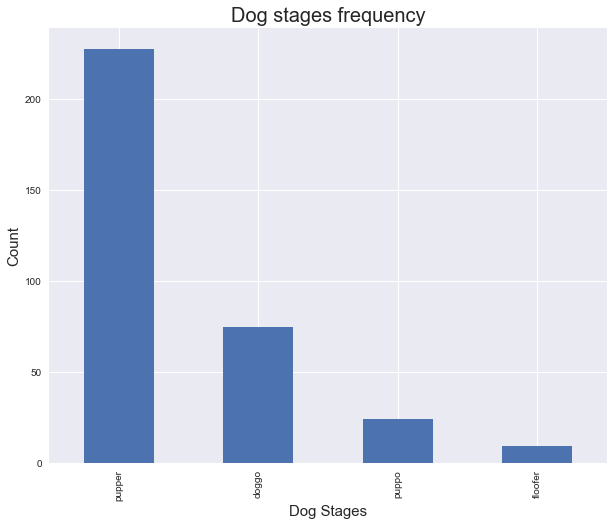

In [89]:
dog_stages = df_main_clean.dog_stage.value_counts().drop('unknown')
dog_stages.plot(kind= 'bar',figsize = (10,8))
plt.xlabel('Dog Stages',fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.title('Dog stages frequency',fontsize = 20)

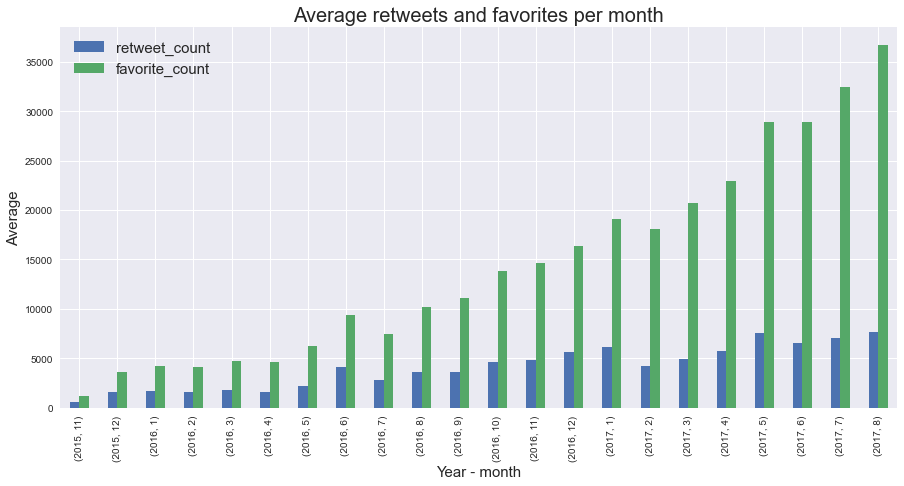

In [90]:
df_main_clean.groupby([df_main_clean.year,df_main_clean.month]).mean().loc[:,'retweet_count':'favorite_count'].plot(kind = 'bar',figsize = (15,7))
plt.xlabel('Year - month',fontsize = 15)
plt.ylabel('Average',fontsize = 15)
plt.title('Average retweets and favorites per month',fontsize = 20)
plt.legend(loc=2, prop={'size': 15})

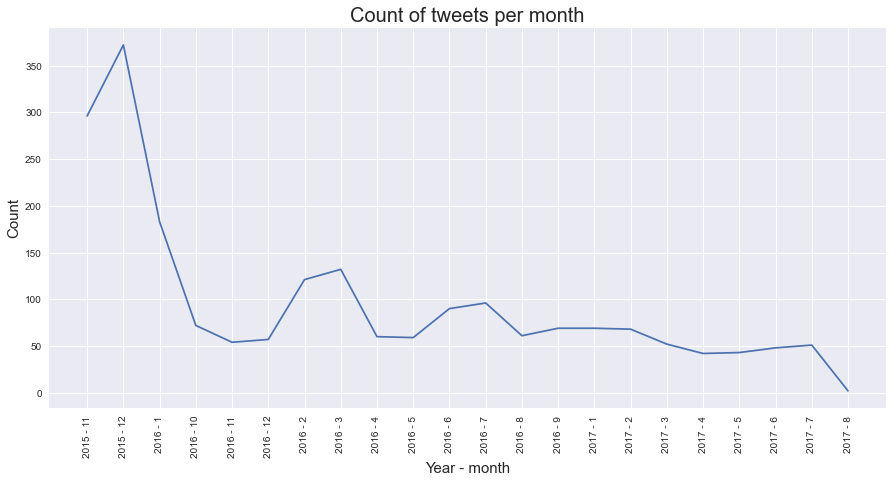

In [91]:
tempdf = df_main_clean.groupby([df_main_clean.year_month]).count().loc[:,'favorite_count']
plt.figure(figsize=(15,7))
plt.plot(tempdf.index,tempdf );
plt.xlabel('Year - month',fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.title('Count of tweets per month',fontsize = 20)
plt.xticks(list(tempdf.index),rotation=90);


<AxesSubplot:ylabel='source'>

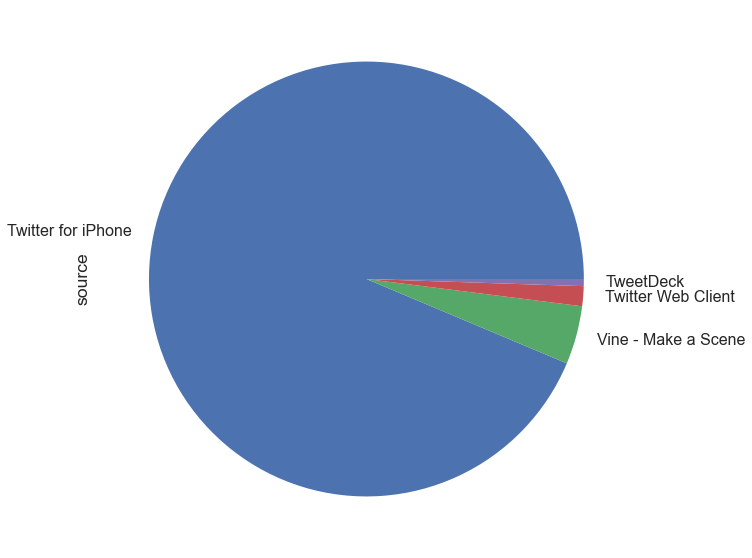

In [92]:
plt.style.use(plt.style.available[20])
df_main_clean.source.value_counts().plot(kind = 'pie',figsize = (10,10))